# Дисперсионный анализ для оценки результатов экспериментов

Задача

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:

1. Проверьте, являются ли дисперсии внутри групп гомогенными.
2. Проведите тест на нормальность распределения.
3. Сравните средние в представленных группах.
4. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
5. Примите решение: какие картинки в итоге будем использовать?
6. Выберите метод для второго теста.
7. Визуализируйте распределение events для контрольной и тестовой групп. 
8. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
9. Выберите формулу для модели, проведите тест.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (16,6)}, style="whitegrid")

import scipy.stats as stats

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [4]:
import os
from pathlib import Path

Импортируем данные и делаем первичные сверки

In [6]:
exp1 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')

In [7]:
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [9]:
exp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
id        30000 non-null int64
group     30000 non-null object
events    30000 non-null int64
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [10]:
exp1.isna().sum()

id        0
group     0
events    0
dtype: int64

In [11]:
exp1.group.value_counts()

A    10000
B    10000
C    10000
Name: group, dtype: int64

## Первый эксперимент: тестируем разрешение фотографий блюд в приложении

Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4

# 1

Проверяем дисперсии внутри групп с помощью теста Левена

In [12]:
a_pc = exp1.query("group == 'A'").events
b_pc = exp1.query("group == 'B'").events
c_pc = exp1.query("group == 'C'").events

In [15]:
stats.levene(a_pc, b_pc, c_pc)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, дисперсии гомогенны

# 2

Проверяем, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность делаем семплирование (1000 наблюдений). Для воспроизводимости результата используем параметр random_state=17 в методе sample.

In [18]:
stats.shapiro(a_pc.sample(1000, random_state=17))

(0.9973153471946716, 0.09609563648700714)

In [19]:
stats.shapiro(b_pc.sample(1000, random_state=17))

(0.9980798363685608, 0.31768906116485596)

In [20]:
stats.shapiro(c_pc.sample(1000, random_state=17))

(0.9981185793876648, 0.3359004259109497)

Распределение events во всех группах является нормальным

# 3

Для сравнения средних применим однофакторный дисперсионный анализ

In [24]:
stats.f_oneway(a_pc, b_pc, c_pc)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Значение p-уровня значимости близко к нулю, предполагаем наличие статистически значимых различий

# 4

Используем критерий Тьюки, чтобы определить, между какими группами есть статистически значимые различия

In [27]:
print(pairwise_tukeyhsd(exp1['events'], groups=exp1['group']).summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Тест показал, что различия есть между каждой парой групп

Визуализируем доверительные интервалы

Text(0, 0.5, 'Кол-во покупок')

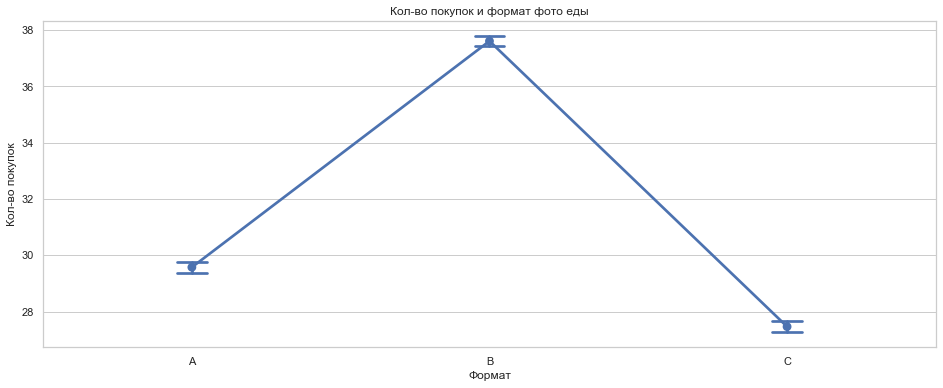

In [28]:
sns.pointplot(x = 'group', y = 'events', data = exp1, capsize = .1)
plt.title('Кол-во покупок и формат фото еды')
plt.xlabel('Формат')
plt.ylabel('Кол-во покупок')

## 5 Выводы по первому эксперименту: наилучшие результаты (и статистически значимые) показывают квадратные картинки (группа В)

## Второй эксперимент: тестируем новую кнопку заказа

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Импортируем данные и делаем первичные сверки

In [32]:
exp2 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_2.csv')

In [33]:
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [34]:
exp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
id         100000 non-null int64
group      100000 non-null object
segment    100000 non-null object
events     100000 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [35]:
exp2.isna().sum()

id         0
group      0
segment    0
events     0
dtype: int64

In [36]:
exp2.group.value_counts()

control    50000
test       50000
Name: group, dtype: int64

# 6 

Метод, который приходится в этом случае - это многофакторный дисперсионный анализ

# 7

Визуализируем распределение количества событий для контрольной (А) и тестовой (В) групп

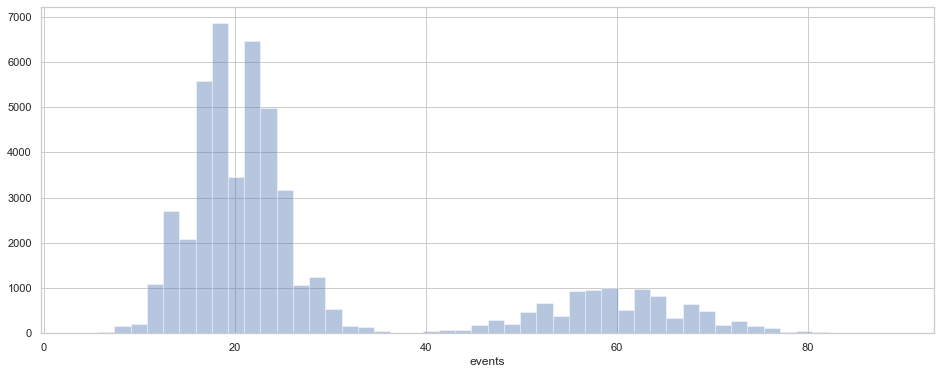

In [38]:
sns.distplot(exp2.query("group == 'control'").events, kde=False)

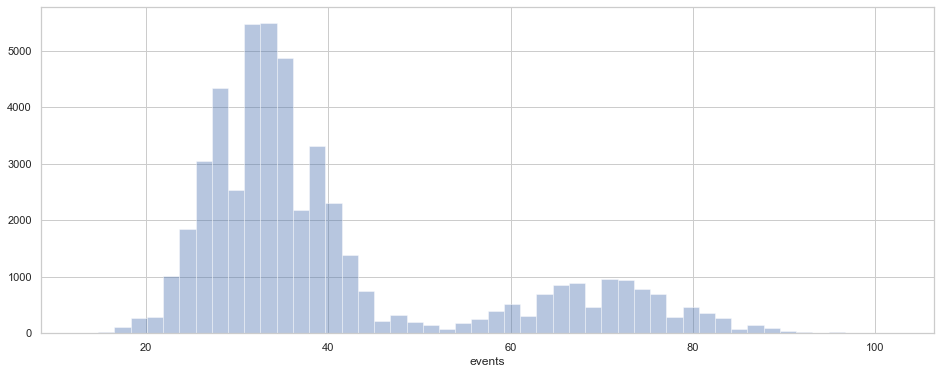

In [39]:
sns.distplot(exp2.query("group == 'test'").events, kde=False)

# 8

Посчитаем медиану, среднее и стандартное отклонения events в разбивке по группе и по сегменту пользователя

In [43]:
exp2.groupby(['group', 'segment']).events.describe().T.round()

group    control              test         
segment     high      low     high      low
count    10000.0  40000.0  10000.0  40000.0
mean        60.0     20.0     70.0     33.0
std          8.0      4.0      8.0      6.0
min         31.0      4.0     40.0     13.0
25%         55.0     17.0     64.0     29.0
50%         60.0     20.0     70.0     33.0
75%         65.0     23.0     76.0     37.0
max         89.0     41.0    102.0     59.0

# 9

Применяем многофакторный дисперсионный анализ

In [46]:
model = ols(formula='events ~ segment + group + segment:group', data = exp2).fit()
aov_table = anova_lm(model, typ=2)
print(round(aov_table, 2))

                    sum_sq       df          F  PR(>F)
segment        23624796.65      1.0  689756.38     0.0
group           3837195.41      1.0  112031.86     0.0
segment:group     36642.44      1.0    1069.82     0.0
Residual        3424955.89  99996.0        NaN     NaN


И сегмент, и группа, и их взаимодействие являются значимыми

Чтобы сравнить наши группы с помощью критерия Тьюки, соединяем их в одну переменную 

In [47]:
exp2['combination'] = exp2.group + ' \ ' + exp2.segment

In [48]:
exp2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


Используем критерий Тьюки, чтобы определить, между какими группами есть статистически значимые различия

In [49]:
print(pairwise_tukeyhsd(exp2['events'], groups=exp2['combination']).summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control \ high control \ low -39.9392 0.001 -40.1073 -39.7711   True
control \ high   test \ high   9.9677 0.001   9.7551  10.1803   True
control \ high    test \ low -26.9449 0.001  -27.113 -26.7768   True
 control \ low   test \ high  49.9069 0.001  49.7388   50.075   True
 control \ low    test \ low  12.9944 0.001   12.888  13.1007   True
   test \ high    test \ low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой

Визуализируем различия

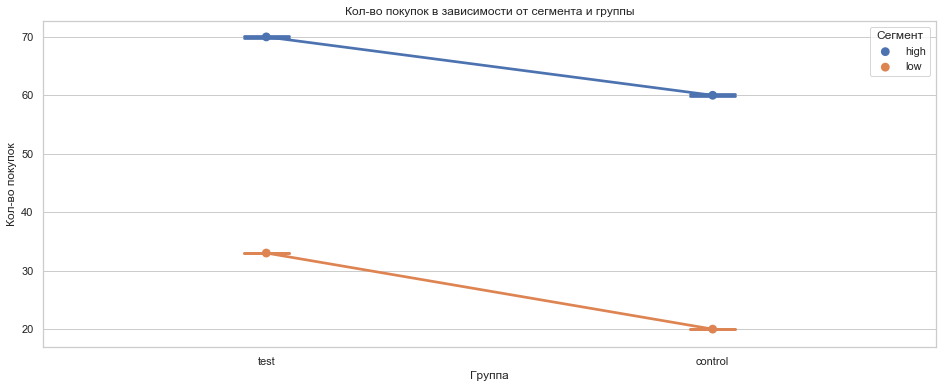

In [52]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = exp2, capsize = .1)
plt.title('Кол-во покупок в зависимости от сегмента и группы')
plt.xlabel('Группа')
plt.ylabel('Кол-во покупок')
plt.legend(title = 'Сегмент')

## Выводы по второму эксперименту: фактор group оказался  значимым, фактор segment –  значимым , их взаимодействие –   тоже значимым. Судя по графику, для всех групп среднее значение events  увеличилось, поэтому нужно выкатывать новую версию кнопки на всех пользователей